## <p style="background-color:snow; font-family:newtimeroman; font-size:180%; text-align:center">Introduction</p>

Emotion Detection and Recognition from text is a recent field of research that is closely related to Sentiment Analysis. Sentiment Analysis aims to detect positive, neutral, or negative feelings from text, whereas Emotion Analysis aims to detect and recognize types of feelings through the expression of texts, such as anger, disgust, fear, happiness, sadness, and surprise.

![emotions](https://assets.website-files.com/57e49495d82fa82e4e44886a/5df791c1fbd9263d6068a453_Should%20You%20Accept%20or%20Regulate%20Your%20Emotions.png)

One of the challenges in emotion detection is the lack of a labelled emotion database to enable active innovation. But we have a datset here that is labelled with 13 emotions. Let's look at it.

### Reading data

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt # plotting
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('tweet_emotions.csv', delimiter=',')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


## <p style="background-color:snow; font-family:newtimeroman; font-size:180%; text-align:center">EDA</p>

In [3]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

In [4]:
basic_eda(df)

Info : There are 3 columns in the dataset
Info : There are 40000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['sentiment', 'content']
Numerical columns :  ['tweet_id']


,column_name,dtype
0,tweet_id,int64
1,sentiment,object
2,content,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,tweet_id,40000.0,1.845184e+09,1.188579e+08,1.693956e+09,1.751431e+09,1.855443e+09,1.962781e+09,1.966441e+09



Description of categorical variables


,column_name,count,unique,top,freq
0,sentiment,40000,13,neutral,8638
1,content,40000,39827,I just received a mothers day card from my lov...,14


In [5]:
# Quickly check for mising values
total = df.isnull().sum()
total

tweet_id     0
sentiment    0
content      0
dtype: int64

### Distribution of sentiments in the data

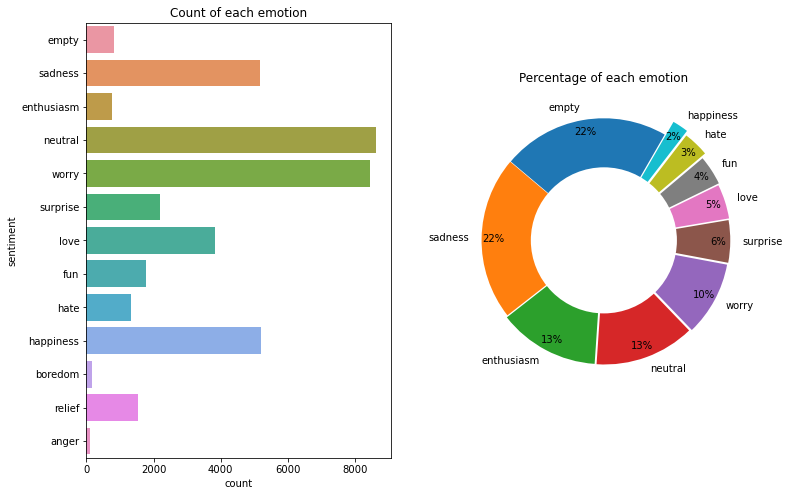

In [6]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

#### We can see that there are 13 different classes and some of them have few examples. Because of this, it is a very unbalanced data set and we believe that it is not good for the model. Therefore, we will reduce the number of classes.



In [7]:
df['sentiment'] = df['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'neutral', 'love'] else "other") 

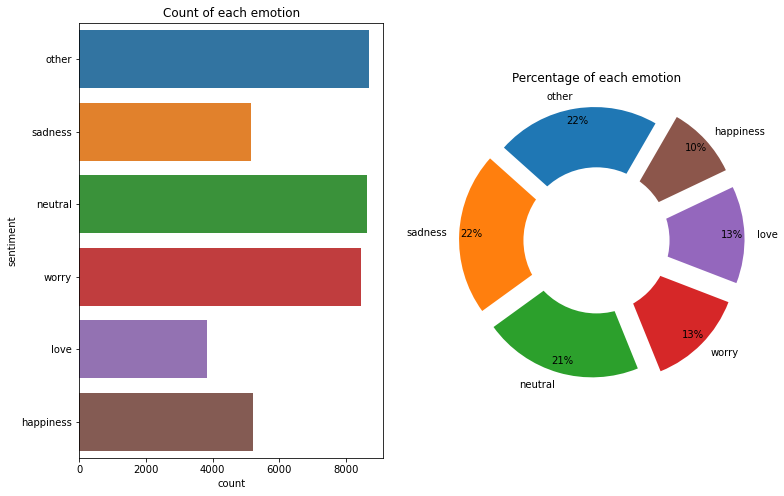

In [8]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [9]:
df['char_length'] = df['content'].apply(lambda x : len(x))
df['token_length'] = df['content'].apply(lambda x : len(x.split(" ")))

### Distribution of character length and token length overall

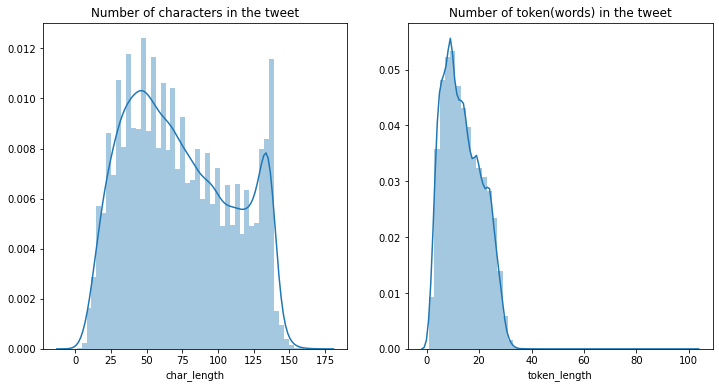

In [10]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(df['char_length'], ax=ax1)
sns.distplot(df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()

### Distribution of character length sentiment-wise [Top 5 sentiments]

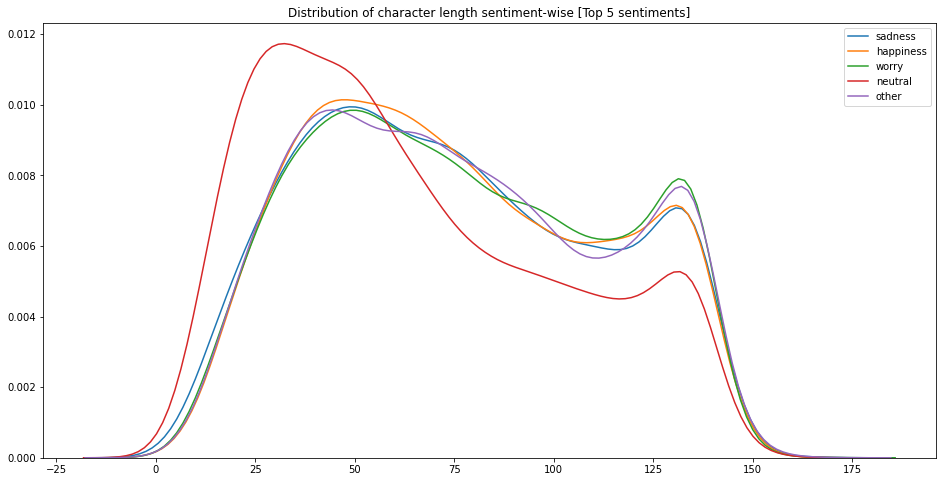

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
for sentiment in df['sentiment'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['char_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 5 sentiments]")
plt.show()

### Distribution of token length sentiment-wise [Top 5 sentiments]

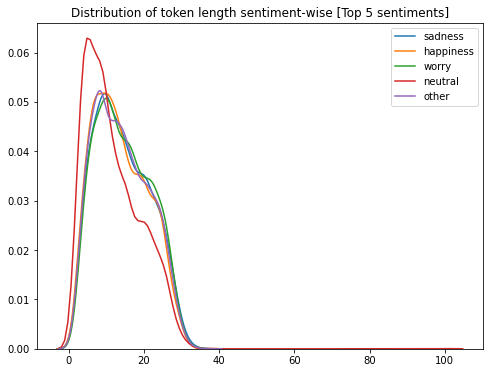

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
for sentiment in df['sentiment'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['token_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of token length sentiment-wise [Top 5 sentiments]")
plt.show()

### Let's look at the most common character and token length

In [13]:
avg_df = df.groupby('sentiment').agg({'char_length':'mean', 'token_length':'mean'})

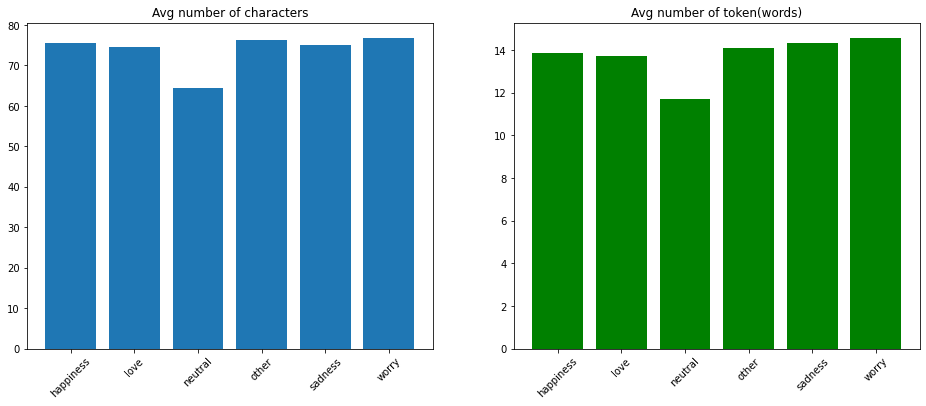

In [14]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

Observations 
- There are 13 different emotions.
- "Neurtal" and "Worry" are the most frequent emotions in the dataset.
- Most of the tweets have around 45 characters.
- The most frequent token length is around 10.
- people having "empty" and "neutral" emotion write smaller tweet.

## <p style="background-color:snow; font-family:newtimeroman; font-size:180%; text-align:center">Text Processing</p>

In [15]:
# Data preparation and text-preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [16]:
#### text preprocessing

def text_preprocessing_platform(df, text_col, remove_stopwords=True):
    
    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text
    
    ## Next step is text-normalization
    
    # Text normalization includes many steps.
    
    # Each function below serves a step.
    
    
    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words
    
    
    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words
    
    
    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    
    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words
    
    
    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words
    
    
    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems
    
    
    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas
    
    
    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words
    
    # All above functions work on word tokens we need a tokenizer
    
    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)
    
    
    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text
    
    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]
    
    
    # return processed df
    return df

In [17]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
print("Before Text Preprocessing")
display(df.head()[['content']])
processed_df = text_preprocessing_platform(df, 'content', remove_stopwords=False)
print("After Text Preprocessing")
display(processed_df.head()[['content']])

Before Text Preprocessing


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content
0,@tiffanylue i know i was listenin to bad habi...
1,Layin n bed with a headache ughhhh...waitin o...
2,Funeral ceremony...gloomy friday...
3,wants to hang out with friends SOON!
4,@dannycastillo We want to trade with someone w...


After Text Preprocessing


,content
0,tiffanylue know listenin bad habit earlier sta...
1,layin n bed headache ughhhh waitin call
2,funeral ceremony gloomy friday
3,want hang friends soon
4,dannycastillo want trade someone houston ticke...


## <p style="background-color:snow; font-family:newtimeroman; font-size:180%; text-align:center">Model Development</p>

In [18]:
#Test and training
    
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(processed_df['content'],processed_df['sentiment'],test_size=0.3) 

In [19]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [20]:
#Vetorization of words

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(processed_df['content'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

### Naive Bayes

In [21]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score -> ",metrics.accuracy_score(predictions_NB, Test_Y))
print("Naive Bayes Precision Score -> ",metrics.precision_score(predictions_NB, Test_Y, average='micro'))
print("Naive Bayes Recall Score -> ",metrics.recall_score(predictions_NB, Test_Y, average='micro'))
print("Naive Bayes F1 Score -> ",metrics.f1_score(predictions_NB, Test_Y, average='micro'))

Naive Bayes Accuracy Score ->  0.3124166666666667
Naive Bayes Precision Score ->  0.3124166666666667
Naive Bayes Recall Score ->  0.3124166666666667
Naive Bayes F1 Score ->  0.3124166666666667


### SVM

In [22]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))

SVM Accuracy Score ->  0.34425


In [ ]:
SVM = svm.SVC(C=1.0, kernel='poly', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))

In [ ]:
SVM = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))

In [ ]:
SVM = svm.SVC(C=1.0, kernel='sigmoid', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))

In [ ]:
SVM = svm.SVC(C=1.0, kernel='precomputed', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y))

### Fuzzy c means